In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.io import loadmat

% matplotlib inline

In [2]:
def gauss_kernel(x1, x2, sigma):
    """Takes two matrices of vectors and returns gauss kernel"""
    M = distance_matrix(x1, x2)
    K =  np.exp(-0.5 / sigma**2 * M**2) 
    return K

In [3]:
def simplified_smo(X, y, C=1, tol=1e-5, max_passes=3, sigma=0.1):
    """ cs229 simplified smo algorithm
        http://cs229.stanford.edu/materials/smo.pdf"""
    m, n = X.shape
    # calculate kernel matrix
    K =  gauss_kernel(X, X, sigma)
    
    alpha = np.zeros(m)
    b = 0
    passes = 0    
    while passes < max_passes:
        num_changed_alphas = 0
        
        for i in range(m):
            # calculate error E_i
            E_i = np.sum(alpha * y * K[i]) + b - y[i]
            
            if ((y[i] * E_i < -tol and alpha[i] < C) or 
                (y[i] * E_i > tol and alpha[i] > 0)):
                # randomly select j!=i
                j = np.random.choice(np.delete(np.arange(m), i))
                E_j = np.sum(alpha * y * K[j]) + b - y[j]
                # save old alphas
                alpha_i_old, alpha_j_old = alpha[i], alpha[j]
                # calculate bounds for alphas
                if (y[i] != y[j]):
                    L = max(0, alpha_j_old - alpha_i_old)
                    H = min(C, C + alpha_j_old - alpha_i_old)
                else:
                    L = max(0, alpha_j_old + alpha_i_old - C)
                    H = min(C, alpha_j_old + alpha_i_old)
                if (L == H): continue
                # calculate eta
                eta = 2 * K[i][j] - K[i][i] - K[j][j]
                if eta >= 0: continue
                # calculate new, unclipped alpha
                alpha_unclipped = alpha_j_old - y[j] * (E_i - E_j) / eta
                if alpha_unclipped > H: alpha[j] = H
                elif alpha_unclipped < L: alpha[j] = L
                else: alpha[j] = alpha_unclipped
                    
                if abs(alpha[j] - alpha_j_old) < tol: continue
                # update alpha    
                alpha[i] = alpha_i_old + y[i] * y[j] * (alpha_j_old - alpha[j])
                # calculate thresholds b1 & b2 
                b1 = b - E_i - y[i] * (alpha[i] - alpha_i_old) * K[i][i] - \
                                        y[j] * (alpha[j] - alpha_j_old) * K[i][j]
                b2 = b - E_j - y[i] * (alpha[i] - alpha_i_old) * K[i][j] - \
                                        y[j] * (alpha[j] - alpha_j_old) * K[j][j]
                # choose b which satisfies KKT conditions
                if 0 < alpha[i] < C:   b = b1
                elif 0 < alpha[j] < C: b = b2
                else: b = (b1 + b2) / 2
                    
                num_changed_alphas += 1
        
        if num_changed_alphas == 0: passes += 1
        else: passes = 0
    
    w = np.dot((alpha * y).T, X).T            
    return alpha, b, w                

In [4]:
def predict(x, alpha, b, X, y, sigma):    
    # select indices with nonzero alphas
    nonzero_indexes = np.nonzero(alpha)
    # create new matrices, where only elements corresponding to 
    # nonzero alphas left
    nonzero_alpha = np.take(alpha, nonzero_indexes, axis=0)
    nonzero_y = np.take(y, nonzero_indexes, axis=0)
    nonzero_X = np.take(X, nonzero_indexes, axis=0)
    # remove extra dimension
    alpha_new = np.squeeze(nonzero_alpha, axis=0)    
    y_new = np.squeeze(nonzero_y, axis=0)    
    X_new = np.squeeze(nonzero_X, axis=0)
    # make predictions
    K = gauss_kernel(X_new, x, sigma)
    target = np.dot((alpha_new*y_new).reshape(1, len(alpha_new)), K) + b
    target[target > 0] = 1
    target[target < 0] = -1    
    return target

In [5]:
def get_mesh(X, h=0.01):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, points      

In [6]:
def plot(X, y, xx, yy, target, graph_title):
    plt.figure(figsize=(8,6))
    # make scatter plot of data
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha = 0.5)
    
    target = np.array(target).reshape(xx.shape)    
    plt.contour(xx, yy, target, levels=[0], linewidths = 2)
    plt.title(graph_title)
    plt.show()  

# Separable data

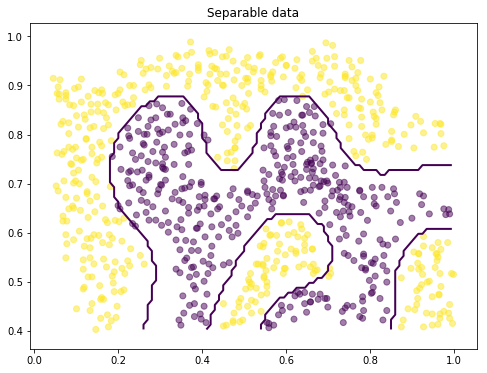

In [7]:
data = loadmat('ex6data2.mat')
X, y = data['X'], data['y'].flatten()
y = 2. * y - 1.

alpha, b, w = simplified_smo(X, y, C=1, tol=1e-5, max_passes=3, sigma=0.1)
xx, yy, points = get_mesh(X, h=0.01)
target = predict(points, alpha, b, X, y, sigma=0.1)
    
plot(X, y, xx, yy, target, graph_title='Separable data')

# Non-separable data

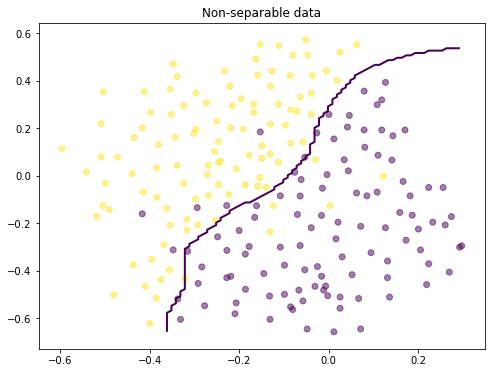

In [8]:
data = loadmat('ex6data3.mat')
X2, y2 = data['X'], data['y'].flatten()
y2 = 2. * y2 - 1.

alpha2, b2, w2 = simplified_smo(X2, y2, C=1, tol=1e-5, max_passes=3, sigma=0.1)
xx2, yy2, points2 = get_mesh(X2, h=0.01)
target2 = predict(points2, alpha2, b2, X2, y2, sigma=0.1)

plot(X2, y2, xx2, yy2, target2, graph_title='Non-separable data')